In [1]:
import numpy as np
import imageio
from skimage import transform
import matplotlib.pyplot as plt
from math import sqrt
import glob
import subprocess

import h5py
from tqdm import tqdm
import knn_cnn_features
import sound_similarity_inference
%matplotlib inline

In [2]:
p = subprocess.Popen("ffmpeg -i data/videos/animals/2.mp4 -f wav -vn data/tmp/animals_0.wav", \
                     stdout=subprocess.PIPE, shell=True)
(output, err) = p.communicate()
p_status = p.wait()

Checking if there is an audio channel. If not, the output audio stream will be empty.

In [3]:
p = subprocess.Popen("ffprobe -i data/videos/animals/0.mp4 -show_streams -select_streams a -loglevel error"\
                     , stdout=subprocess.PIPE, shell=True)
(output, err) = p.communicate()
p_status = p.wait()

In [4]:
"No audio channel" if output.decode()=='' else "Audio channels present:"+output.decode()

'No audio channel'

In [5]:
!ffprobe -i data/videos/animals/0.mp4 -show_streams -select_streams a -loglevel error

In [6]:
p = subprocess.Popen("ffprobe -i /home/hemant/Videos/Titans\ -\ Season\ 1.mp4 -show_streams -select_streams a -loglevel error", \
                     stdout=subprocess.PIPE, shell=True)
(output, err) = p.communicate()
p_status = p.wait()

In [7]:
"No audio channel" if output.decode()=='' else "Audio channels present:"+output.decode()

'Audio channels present:[STREAM]\nindex=1\ncodec_name=aac\ncodec_long_name=AAC (Advanced Audio Coding)\nprofile=LC\ncodec_type=audio\ncodec_time_base=1/44100\ncodec_tag_string=mp4a\ncodec_tag=0x6134706d\nsample_fmt=fltp\nsample_rate=44100\nchannels=2\nchannel_layout=stereo\nbits_per_sample=0\nid=N/A\nr_frame_rate=0/0\navg_frame_rate=0/0\ntime_base=1/44100\nstart_pts=0\nstart_time=0.000000\nduration_ts=114762752\nduration=2602.329977\nbit_rate=125588\nmax_bit_rate=N/A\nbits_per_raw_sample=N/A\nnb_frames=112073\nnb_read_frames=N/A\nnb_read_packets=N/A\nDISPOSITION:default=1\nDISPOSITION:dub=0\nDISPOSITION:original=0\nDISPOSITION:comment=0\nDISPOSITION:lyrics=0\nDISPOSITION:karaoke=0\nDISPOSITION:forced=0\nDISPOSITION:hearing_impaired=0\nDISPOSITION:visual_impaired=0\nDISPOSITION:clean_effects=0\nDISPOSITION:attached_pic=0\nDISPOSITION:timed_thumbnails=0\nTAG:creation_time=2018-12-03T23:09:27.000000Z\nTAG:language=eng\nTAG:handler_name=ISO Media file produced by Google Inc. Created on: 12

In [8]:
p = subprocess.Popen("ffmpeg -i /home/hemant/Videos/Titans\ -\ Season\ 1.mp4 -f wav -vn data/tmp/animals_0.wav", \
                     stdout=subprocess.PIPE, shell=True)
(output, err) = p.communicate()
p_status = p.wait()

In [9]:
# The file is huge. Taking a small chunk of it and delete the larger chunk
!ffmpeg -t 30 -i data/tmp/animals_0.wav data/tmp/mini_0.wav -loglevel error && rm animals_0.wav

In [10]:
# sample script to create a log_mel_spectrogram
from scipy.io import wavfile
from scipy import signal

sample_rate=16000
window_size=20
step_size=10
eps=1e-10
rate, data = wavfile.read('data/tmp/mini_0.wav')
if data.ndim > 1 : # ignore  channels 2+
    data = data[:, 0]
nperseg = int(round(window_size * sample_rate / 1e3))
noverlap = int(round(step_size * sample_rate / 1e3))
freqs, times, spec = signal.spectrogram(data,fs=sample_rate,window='hann',nperseg=nperseg,noverlap=noverlap)
log_specgram = np.log(spec.T.astype(np.float32) + eps)

In [11]:
print(log_specgram.shape)

(8267, 161)


In [3]:
import sys
sys.path.append("audioset/")

The module **vggish_input** has a function **wavfile_to_examples** which returns the log_mel_spectrogram (after correction intro standard form) of the input **wav_file**.

In [4]:
import vggish_input
features_tensor = vggish_input.wavfile_to_examples(wav_file='data/tmp/mini_0.wav')

827 ms ± 20 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [5]:
features_tensor.shape

(31, 96, 64)

The module **vggish_inference** has a function **main** which returns the vggish extracted embedding (from the log_mel_spectrogram that is in turn created by vggish_input) of the input **wav_file**.

In [6]:
import vggish_inference
embedding_batch, postprocessed_batch = vggish_inference.main(wav_file='data/tmp/mini_0.wav')

INFO:tensorflow:Restoring parameters from audioset/vggish_model.ckpt


1.94 s ± 6.51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [16]:
embedding_batch.shape

(31, 128)

Here $31$ is the time in seconds of the audio stream and $128$ is the dimensionality of the extracted vggish embedding.

### Read extracted audioset embeddings

In [1]:
import tensorflow as tf
import numpy as np
import glob 
tf.enable_eager_execution()

files = sorted(glob.glob('audioset/data/audioset_v1_embeddings/bal_train/*'))

In [2]:
def readTfRecords(tfrecords_filename, verbose = False, std_frames=10):
    multiple_audio_embedding = []
    labels = []

    record_iterator = tf.python_io.tf_record_iterator(path=tfrecords_filename)
    for string_record in record_iterator:
        example = tf.train.SequenceExample.FromString(string_record)
        label = np.array(example.context.feature['labels'].int64_list.value)
        n_frames = len(example.feature_lists.feature_list['audio_embedding'].feature)
        audio_embedding = []
        for i in range(n_frames):
            audio_embedding.append(tf.cast(tf.decode_raw(example.feature_lists.feature_list['audio_embedding']\
                        .feature[i].bytes_list.value[0],tf.uint8),tf.float32).numpy())
        audio_embedding = np.array(audio_embedding)
        
        if n_frames==std_frames:
            labels.append(label)
            multiple_audio_embedding.append(audio_embedding)
        if verbose:
            print('labels: ' + str(label))
            print(audio_embedding.shape)
    return np.array(multiple_audio_embedding), labels

In [4]:
%time multiple_audio_embedding, labels = readTfRecords(files[1])

CPU times: user 40.1 ms, sys: 19 ms, total: 59.1 ms
Wall time: 44.8 ms


In [5]:
multiple_audio_embedding.shape, len(labels)

((8, 10, 128), 8)

In [6]:
len(files)

4070

In [6]:
from tqdm import tqdm
import h5py

In [7]:
all_audio_embedding = np.zeros((22176,10,128))
all_labels = []
pos = 0
for file in tqdm(files):
    multiple_audio_embedding, labels = readTfRecords(file)
    length = len(labels)
    if multiple_audio_embedding.shape!=(0,):
        try:
            all_audio_embedding[pos:(pos+length),] = np.array(multiple_audio_embedding)
            all_labels = all_labels + labels
            pos+=length
        except:
            print(multiple_audio_embedding.shape,file, length)
            break

100%|██████████| 4070/4070 [01:04<00:00, 63.43it/s]


In [8]:
all_audio_embedding = all_audio_embedding[:pos,]

In [9]:
all_audio_embedding.shape, len(all_labels)

((21782, 10, 128), 21782)

In [11]:
audioset_h5f = h5py.File('audioset_balanced_features_vggish.h5', 'w')
audioset_h5f.create_dataset('audio_embeddings', data=all_audio_embedding)
audioset_h5f.close()

<HDF5 dataset "audio_embeddings": shape (21782, 10, 128), type "<f8">

In [12]:
np.save('audioset_balanced_labels.npy', all_labels)

In [2]:
flat_labels = [item for sublist in all_labels for item in sublist]
# from collections import Counter
# Counter(flat_labels)

## KNN for Sound Similarity

In [8]:
audioset_h5f = h5py.File('audioset_balanced_features_vggish.h5', 'r')
audio_embeddings = np.array(audioset_h5f['audio_embeddings'],dtype='float32')
audioset_h5f.close()

In [24]:
feature_labels = np.load('audioset_balanced_labels.npy')
feature_labels = np.array([flab[0] for flab in feature_labels])

In [9]:
audio_embeddings.shape

(21782, 10, 128)

In [10]:
reshaped_audio_embeddings = audio_embeddings.reshape(audio_embeddings.shape[:-2] + (-1,))
reshaped_audio_embeddings.shape

(21782, 1280)

In [15]:
%time feature_indices = knn_cnn_features.run_knn_features(reshaped_audio_embeddings,k=3)

CPU times: user 354 ms, sys: 221 ms, total: 576 ms
Wall time: 575 ms


In [29]:
similar_videos = feature_labels[feature_indices]

In [4]:
def get_cls_accuracy(similar_videos, feature_labels, k=3):
    accuracy = 0
    for i, sim_vids in enumerate(similar_videos):
        true_label = feature_labels[i]
        for sim_vid in sim_vids:
            pred_label = sim_vid
            accuracy += np.sum(pred_label==true_label)/k
    return accuracy/len(feature_labels)

In [33]:
print("Accuracy:",get_cls_accuracy(similar_videos,feature_labels))

Accuracy: 0.47364796621067323


In [35]:
len(set(feature_labels))

448

Therefore we see a class-wise accuracy of $47\%$ for the $448$ classes of audioset. Although the accuarcy is not high, this can be attributed to the following:

    1. The larger number of class labels i.e. nearly 500.
    2. The fact that we have considered only the first class label for each of the audio clips.
    3. All votes are beening considered for calculating accuracy and not just majority.

In [36]:
# total number of labels (if considering all - not just first)
len(set([item for sublist in feature_labels for item in sublist]))

527

In [47]:
%time feature_indices = knn_cnn_features.run_knn_features(reshaped_audio_embeddings,\
                                                    test_vectors=reshaped_audio_embeddings[:10],k=3)

CPU times: user 13.6 ms, sys: 96 ms, total: 110 ms
Wall time: 109 ms


## Script for getting K similar videos from a new video

In [25]:
import sound_similarity_inference

In [3]:
%time audio_embedding = sound_similarity_inference.embedding_from_audio('data/audio/v_ApplyEyeMakeup_g01_c01.wav')

INFO:tensorflow:Restoring parameters from audioset/vggish_model.ckpt
CPU times: user 1.28 s, sys: 245 ms, total: 1.53 s
Wall time: 940 ms


In [2]:
audio_embeddings, audio_labels, true_indices = sound_similarity_inference.load_sound_data()

In [3]:
%time similar_indices = sound_similarity_inference.similar_sound_embedding(audio_embeddings[:1],k=10)

CPU times: user 1.12 s, sys: 373 ms, total: 1.49 s
Wall time: 807 ms


In [4]:
output = sound_similarity_inference.label_from_index(similar_indices[0], true_indices[0])

In [10]:
print(output[0],"\n",output[1])

['Smoke detector, smoke alarm' 'Alarm clock' 'Alarm clock' 'Boing'
 'Emergency vehicle' 'Caw' 'Grunge' 'Music' 'Music' 'Silence'] 
 ['Smoke detector, smoke alarm']


## KNN with second wise similarity

In [2]:
audioset_h5f = h5py.File('audioset_balanced_features_vggish.h5', 'r')
audio_embeddings = np.array(audioset_h5f['audio_embeddings'],dtype='float32')
audioset_h5f.close()
    
feature_labels = np.load('audioset_balanced_labels.npy')
feature_labels = np.array([flab[0] for flab in feature_labels])

In [3]:
merged_audio_embeddings = audio_embeddings.reshape(audio_embeddings.shape[:-3] + (-1,128))
embedding_labels = np.array([i for i in feature_labels for _ in range(10)])

In [27]:
merged_audio_embeddings.shape, len(embedding_labels)

((217820, 128), 217820)

In [31]:
%time feature_indices = knn_cnn_features.run_knn_features(merged_audio_embeddings,k=3)

CPU times: user 5.39 s, sys: 2.34 s, total: 7.73 s
Wall time: 7.74 s


In [37]:
similar_videos = embedding_labels[feature_indices]
print("Accuracy:",get_cls_accuracy(similar_videos,embedding_labels))

Accuracy: 0.6625822544591378


#### Using a train test split for KNN (70:30) to test accuracy for second-level KNN

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(merged_audio_embeddings, embedding_labels, \
                                        test_size=0.3, random_state=42)

In [10]:
%time feature_indices = knn_cnn_features.run_knn_features(X_train,test_vectors=X_test,k=3)

CPU times: user 977 ms, sys: 479 ms, total: 1.46 s
Wall time: 1.45 s


In [11]:
similar_videos = y_train[feature_indices]
print("Accuracy:",get_cls_accuracy(similar_videos,y_test))

Accuracy: 0.43782327915966457


In [8]:
def get_ordered_unique(listed):
    seen = set()
    seen_add = seen.add
    return [x for x in listed if not (x in seen or seen_add(x))]

In [23]:
get_ordered_unique(similar_videos[0])

[137, 211]

#### Time for $1$ queries over $200,000$ frames of $128$ dimensionality:

In [7]:
%timeit feature_indices = knn_cnn_features.run_knn_features(merged_audio_embeddings,\
                                                        test_vectors=X_test[:1],k=3)

105 ms ± 5.16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Extract Sound features from UCF101

In [2]:
videos = sorted(glob.glob("data/UCF101/*"))
ucf_classes = [vid.split('/')[-1].split('_')[1] for vid in videos]
ucf_classes = sorted(list(set(ucf_classes)))

In [3]:
def audio_emb_from_vid(vid_path, vid_name):
    sound_similarity_inference.extract_audio_from_video(vid_path)
    audio_embedding = sound_similarity_inference.embedding_from_audio("data/audio/"+vid_name+".wav")
    return audio_embedding

In [4]:
for vid_path in tqdm(videos):
    vid_name = vid_path.split('/')[-1].split('.')[0]
    try:
        audio_embedding = audio_emb_from_vid(vid_path, vid_name)
        np.save('data/audio/'+vid_name+'.npy', audio_embedding)
    except:
        continue

100%|██████████| 13320/13320 [2:08:45<00:00,  1.72it/s]  


In [4]:
videos = sorted(glob.glob("data/audio/*.npy"))

In [36]:
print("%0.2f" % (len(videos)*100/13320),"% of the videos in the UCF dataset have an audio channel")

51.33 % of the videos in the UCF dataset have an audio channel


In [14]:
feature_vectors = None
audio_labels = []
for vid in tqdm(videos):
    if type(feature_vectors) is not np.ndarray:
        aud_emb = np.load(vid).astype('float32')
        audio_labels = audio_labels + [vid]*aud_emb.shape[0]
        feature_vectors = aud_emb
    else:
        aud_emb = np.load(vid).astype('float32')
        audio_labels = audio_labels + [vid]*aud_emb.shape[0]
        feature_vectors = np.vstack((feature_vectors, aud_emb))

100%|██████████| 6837/6837 [00:20<00:00, 330.70it/s] 


In [15]:
h5f = h5py.File('audio_sec_UCF_vggish.h5', 'w')
h5f.create_dataset('feature_vectors', data=feature_vectors)
h5f.create_dataset('feature_labels', data=np.array(audio_labels, dtype='S'))
h5f.close()

### Second wise similarity UCF

In [3]:
feature_file = h5py.File('audio_sec_UCF_vggish.h5', 'r')
feature_labels = np.array([fl.decode() for fl in feature_file['feature_labels']])
feature_vectors = np.array(feature_file['feature_vectors'])
feature_file.close()

In [20]:
%timeit feature_indices = knn_cnn_features.run_knn_features(feature_vectors,k=3)

479 ms ± 7.27 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
def get_cls_accuracy_ucf(similar_videos, feature_labels, k=3):
    accuracy = 0
    for i, sim_vids in enumerate(similar_videos):
        true_label = feature_labels[i].split('_')[1]
        for sim_vid in sim_vids:
            pred_label = sim_vid.split('_')[1]
            accuracy += np.sum(pred_label==true_label)/k
    return accuracy/len(feature_labels)

In [26]:
similar_videos = feature_labels[feature_indices]
print("Accuracy:",get_cls_accuracy_ucf(similar_videos,feature_labels))

Accuracy: 0.7794387394018154


### Using a train test split for KNN (70:30) to test accuracy

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(feature_vectors, feature_labels, \
                                        test_size=0.3, random_state=42)

In [28]:
%timeit feature_indices = knn_cnn_features.run_knn_features(X_train,test_vectors=X_test,k=3)

161 ms ± 1.74 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [5]:
feature_indices = knn_cnn_features.run_knn_features(X_train,test_vectors=X_test,k=3)

In [7]:
similar_videos = y_train[feature_indices]
print("Accuracy:",get_cls_accuracy_ucf(similar_videos,y_test))

Accuracy: 0.635109763142556


In [8]:
similar_videos_flat = [item.split('_')[1] for sublist in similar_videos for item in sublist]
y_test_flat = [item.split('_')[1] for item in y_test for i in range(3)]

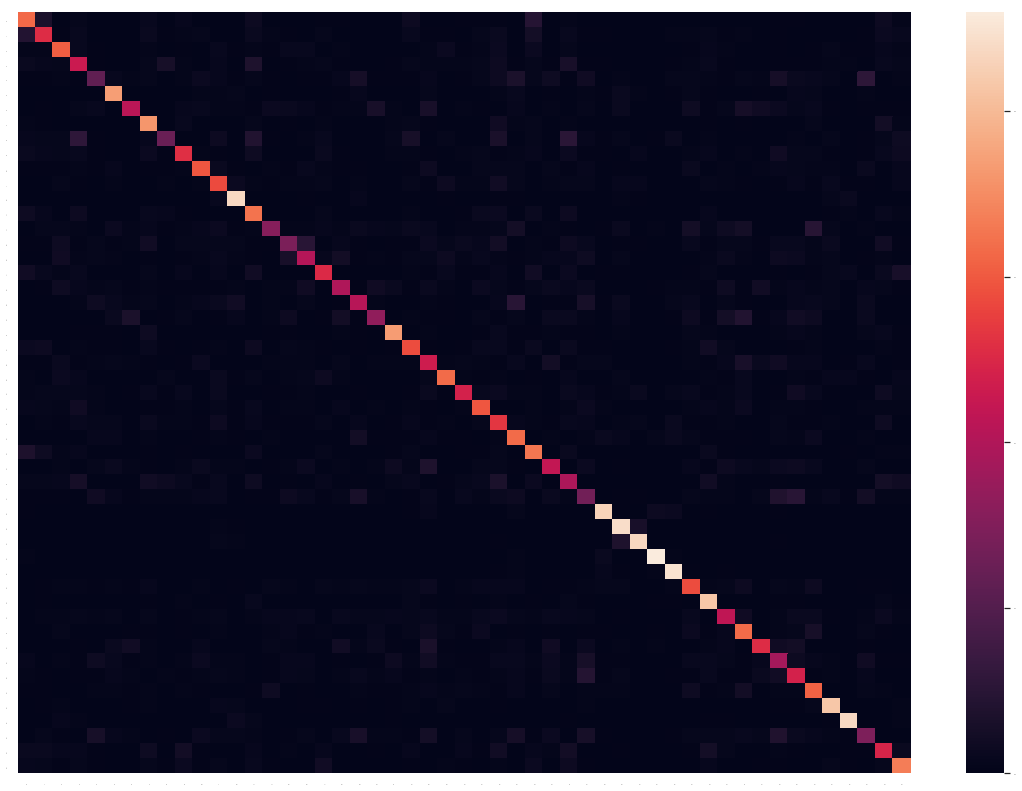

In [10]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test_flat, similar_videos_flat)
cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cnf_matrix, range(51),
                  range(51))
plt.figure(figsize = (20,14))
sn.set(font_scale=0.1)#for label size
sn.heatmap(df_cm, annot=False)# font size ,annot_kws={"size": 16}

In [12]:
notsogood = []
for i, row in enumerate(cnf_matrix):
    for j, colj in enumerate(row):
        if colj > 0.1 and i!=j:
            print(cnf_matrix[i,j])
            notsogood.append([i,j])
for nsgi in notsogood:
    print(ucf_classes[nsgi[1]],"->",ucf_classes[nsgi[0]])

0.1111111111111111
0.11382113821138211
0.10298102981029811
0.10023310023310024
Kayaking -> BalanceBeam
BabyCrawling -> BasketballDunk
FrontCrawl -> BasketballDunk
BoxingPunchingBag -> Bowling
